## Libraries

In [37]:
using KadanoffBaym, LinearAlgebra, BlockArrays
using Bessels
using PyPlot
using Tullio
⊗(A,B) = kron(A,B)

⊗ (generic function with 1 method)

## Parameters and predifined quantities

In [38]:
hbar = 1.#0.658211928e0  
### Pauli matrices
σ_0 = Matrix{ComplexF64}([1. 0. ; 0 1])
σ_x =  Matrix{ComplexF64}([0 1; 1 0])
σ_y =  Matrix{ComplexF64}([0 -1im ; 1im 0 ])
σ_z = Matrix{ComplexF64}([1 0. ; 0. -1]) ; 

In [39]:
# Lattice size
L = 2
nσ = 2
nx = L
ny = 1
γ = 1
γso = 0
j_sd = 0
# Allocate the initial Green functions (time arguments at the end)
GL = GreenFunction(zeros(ComplexF64, nx*nσ, nx*nσ, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, nx*nσ, nx*nσ, 1, 1), SkewHermitian);
# GL_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian)
# GG_d = GreenFunction(zeros(ComplexF64, L, L, 1, 1), SkewHermitian);

### Auxiliary integrator

In [40]:
function integrate0(t1,t2,A)
    retval = 0.0
    dt = 0.01
    ts = t2:dt:t1
    A_vec = A.(ts)
    @tullio retval = A_vec[α]
    retval = retval*dt
end
# Auxiliary integrator for the first type of integral
function integrate1(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t1)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k] - B[t1, k], C[k, t2], hs[k], 1.0)
    end
    return retval
end
# Auxiliary integrator for the second type of integral
function integrate2(hs::Vector, t1, t2, A::GreenFunction, B::GreenFunction, C::GreenFunction; tmax=t2)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:tmax
        @views LinearAlgebra.mul!(retval, A[t1, k], B[k, t2] - C[k, t2], hs[k], 1.0)
    end
    return retval
end

integrate2 (generic function with 1 method)

## Self Energy 

In [5]:
#### Dynamical variables 
Base.@kwdef struct FermiHubbardData2B{T}
    GL::T
    GG::T
    ΣL::T # zero(GL)
    ΣG::T # zero(GG)
end


In [41]:
#### Calculation of the self-energy 
function selfenergy(ϵ;γ=1,γc=1.)# thop = thop, t_ls = 1.) 
    ### Note that this configuration for the self energy can be modified later
    #thop = global_var.thop
    Δ = 4 * γ^2 - ϵ^2
    if real(Δ) > 0
        Σ = ϵ - im * sqrt(Δ)
    else
        if real(ϵ) > 0
            sgn = 1
        else
            sgn = -1
        end
        Σ = ϵ - sgn * sqrt(-Δ)
    end
    Σ = Σ* (γc^2 / (2 * γ^2))
    return Σ
end
function Gamma_ϵ(ϵ;γ=1,γc=1.)#
    -2*imag(selfenergy(ϵ;γ=γ,γc=γc))
end
#using Bessels
function Gamma_t(t;γ=1,γc=1.)#
    γ^2/(γc^2)*γ^2*(besselj(0, 2*γ*t)+ besselj(2, 2*γ*t))#*exp(1im*μ*t)
    #-2*imag(selfenergy(ϵ;γ=γ,γc=γc))
end
function Gamma2_t(t;γ=1,γc=1.)#
    retval = 0.0
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    @tullio retval = Gamma[α]*e[α]
    retval = retval*dϵ/2pi#/(length(ϵs))
end
function fermi_mu(ϵ; μ=0.0, Temp=300)
    KB = 8.6173324e-5           ### Bolzmann factor
   1/(1. + exp((ϵ-μ)/(KB*Temp)  ))   
end
function SelfL(t;γ=1,γc=1.)
    retval = 0.0
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    f = fermi_mu.(ϵs)
    @tullio retval = Gamma[α]*e[α]*f[α]
    retval = 1im*retval*dϵ/2pi
end
function SelfG(t;γ=1,γc=1.)
    retval = 0.0
    dϵ = 0.01
    ϵs = -2γ:dϵ:2γ
    Gamma = Gamma_ϵ.(ϵs;γ,γc)
    e = exp.(-1im*ϵs*t)
    f = -fermi_mu.(ϵs) .+ 1
    @tullio retval = Gamma[α]*e[α]*f[α]
    retval = -1im*retval*dϵ/2pi
end

SelfG (generic function with 1 method)

In [42]:
# Callback function for the self-energies
function self_Lead!(model,data,times,_,_,t,t′)
    # Unpack data and model 
    (;GL,GG,ΣL,ΣG) = data
    (;Δ1, Δ2) = model
    ∫ds(A) = integrate0(times[t],times[t′], A  ) 
    # Resize self energies 
    if (n = size(GL,3)) > size(ΣL,3)
        resize!(ΣL, n)
        resize!(ΣG, n)
    end
    ### Time dependece of the leads 
    ϕ1_t = ∫ds(Δ1)#Δ1(times[t], times[t′] )
    ϕ2_t = ∫ds(Δ2)
    #Δ2_t = Δ2(times[t], times[t′] )
    ### Setting the component of the left self-energy
    self = SelfL(times[t] - times[t′];γ=1.0,γc=1.0)
    selfL0 = zeros(ComplexF64,L*nσ,L*nσ)
    selfL0[1:nσ,1:nσ] = self*exp(-1im*ϕ1_t)*diagm(ones(nσ))### Left lead selfenergy 
    selfL0[end-nσ+1:end,end-nσ+1:end] = self*exp(-1im*ϕ2_t)*diagm(ones(nσ)) ### Right lead selfenergy 
    ### Setting the component of the right self-energy
    self = SelfG(times[t] - times[t′];γ=1.0,γc=1.0)
    selfG0 = zeros(ComplexF64,L*nσ,L*nσ)
    selfG0[1:nσ,1:nσ] = self*exp(-1im*ϕ1_t)*diagm(ones(nσ)) ### Left lead selfenergy 
    selfG0[end-nσ+1:end,end-nσ+1:end] = self*exp(-1im*ϕ2_t)*diagm(ones(nσ)) ### Right lead selfenergy 

    ### Define the self energies 
    ΣL[t, t′] = selfL0#exp()
    ΣG[t, t′] = selfG0
end

self_Lead! (generic function with 1 method)

In [43]:
#SelfL(0.0;γ=1,γc=1.)

In [46]:
# Gamma2_t(0.1)
# 1/(2*pi*0.1)
# ϵs = -4:0.1:4
# length(ϵs)
# ts= 0.1:0.1:50
# # plot(ts,Gamma_t.(ts))
# # plot(ts,Gamma2_t.(ts)/2)
# plot(ts,SelfL.(ts))
# plt.ylim(-0.1,0.1)

# # es=-4:0.1:4
# # # plot(es,real(selfenergy.(es)))
# # # plot(es,imag(selfenergy.(es)))
# # plot(es,Gamma_ϵ.(es))
# SelfG(0)

## Hamiltonian 

In [47]:
############# Building Hamiltonian
#### Create electronic Hamiltonian 
function block_h(;ny=1,γ=1,γso=0.0)
    #γ::Float64,γso::ComplexF64,Bz::Float64,ny::Int)
    "Creates the building blocks for a general nx x ny square lattice "
    dim = ny*2 # We include the spin degree of freedom 
    ######
    H0 = zeros(ComplexF64,dim,dim)
    T  = zeros(ComplexF64,dim,dim)
    One_y = Diagonal(ones(ny))
    ######
    Ty = diagm(-1 =>  ones(ny-1))
    T0 = Ty⊗(-γ*σ_0 - 1im*γso*σ_x)
    H0 .= T0 + T0' #-Bz*kron(One_y, σ_z)
    ######
    T .= One_y⊗(-γ*σ_0 + γso*1im*σ_y)
    return H0, T
end

function hs(vm_i1x::Array{Float64,2};nx=nx,ny=1,γ=1,γso=0.0,j_sd=0.0)
    "This function build the central hamiltonian wwith two band"
    #γ::Float64,γso::ComplexF64,Bz::Float64,nx::Int,ny::Int)
    dim = nx*ny*2 #*2
    zero = zeros(ComplexF64,nx,nx)
    HC = zeros(ComplexF64,dim,dim)
    One_x = Diagonal(ones(nx))
    H0,T = block_h(;ny,γ,γso)
    Tx = diagm( -1 =>  ones(nx-1))⊗T 
    HC = (One_x⊗H0) +  Tx + Tx'
    ### Local moments
    for i in range(1,nx) 
        zero[i,i] = 1.0
        HC += -j_sd*zero⊗(vm_i1x[i,1]*σ_x
                    +vm_i1x[i,2]*σ_y
                    +vm_i1x[i,3]*σ_z)
        zero[i,i] = 0.0
    end
    return HC
end


hs (generic function with 1 method)

In [53]:
#### Auxiliary structure with the parameters of the model 
Base.@kwdef struct FermiOpenModel{T1,T2}
    # interaction strength
    # Time dependence of the self energies 
    Δ1::T1
    Δ2::T2
    #U::T
    nx = nx
    ny = ny
    nσ = nσ
    γ = γ
    γso =  γso
    j_sd = j_sd
    # Initial configuration of the classical vectors 
    #vm_i1x = vm_i1x#zeros(Float64,  nx, 3)
    vm_i1x = zeros(Float64,  L, 3);
    # Hamiltonian of the system 
    hs = hs(vm_i1x;nx,ny,γ,γso,j_sd)
    #H_u = h
    #H_d = h
end
#model.Δ1

## Initial conditions 

In [49]:
# Initial conditions
# Relatively small interaction parameter
U₀ = 0.05
U₁ = 0
model = FermiOpenModel(Δ1 = t1-> U₀,Δ2 = t2-> U₁)
N = zeros(L*nσ)
#vm_i1x = zeros(Float64,  L, 3)
# N_d = zeros(L)
# #######
N[1:4] = 0.0 .* [1, 1, 1, 1]
# N_d[1:4] = 0.1 .* [1, 1, 1, 1]
# #######
# N_u[5:8] = 0.0 .* [1, 1, 1, 1]
# N_d[5:8] = 0.0 .* [1, 1, 1, 1]
# #######
GL[1, 1] = 1.0im * diagm(N)
GG[1, 1] = -1.0im * (I - diagm(N)) ;
ΣL = zero(GL)
ΣG = zero(GG)
ΣL[1,1] = SelfL(0;γ=1.0,γc=1.0)*diagm(ones(L*nσ))
ΣG[1,1] = SelfG(0;γ=1.0,γc=1.0)*diagm(ones(L*nσ))
data = FermiHubbardData2B(GL=GL, GG=GG, ΣL=ΣL, ΣG=ΣG) ;

## EOMS

In [54]:
# Right-hand side for the "vertical" evolution
function fv!(model, data, out, times, h1, h2, t, t′)
    # Unpack data and model
    (; GL, GG, ΣL, ΣG) = data
    (; hs, Δ1, Δ2) = model

    # Real-time collision integrals
    ∫dt1(A, B, C) = integrate1(h1, t, t′, A, B, C)
    ∫dt2(A, B, C) = integrate2(h2, t, t′, A, B, C)
    # Equations of motion
    out[1] = -1.0im * ( hs* GL[t, t′] +
        ∫dt1(ΣG, ΣL, GL) + ∫dt2(ΣL, GL, GG)) #### For G<_up
    out[2] = -1.0im * (hs* GG[t, t′] +
        ∫dt1(ΣG, ΣL, GG) + ∫dt2(ΣG, GL, GG)) #### For G>_up
    return out
end
# Right-hand side for the "diagonal" evolution
function fd!(model, data, out, times, h1, h2, t, t′)
    fv!(model, data, out, times, h1, h2, t, t)
    out[1] .-= adjoint.(out[1])
    out[2] .-= adjoint.(out[2])
end
# Right-hand side for the "diagonal" evolution
function fd!(model, data, out, times, h1, h2, t, t′)
    fv!(model, data, out, times, h1, h2, t, t)
    out .-= adjoint.(out)
end

fd! (generic function with 1 method)

## Evolution

In [55]:
# final time
tmax = 10#80

# tolerances
atol = 1e-8#1e-7#
rtol = 1e-6#1e-4#

# Call the solver
elapsed_time = @elapsed begin
sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> fd!(model, data, x...),
    [data.GL, data.GG],
    (0.0, tmax);
    callback = (x...) -> self_Lead!(model, data, x...),
    atol = atol,
    rtol = rtol,
    stop = x -> (println("time : $(x[end])"); flush(stdout); false)
)
end
println("Total time of simulation: ", elapsed_time, " s" )

time : 0.0
time : 1.0e-6
time : 5.999999999999999e-6
time : 3.0999999999999995e-5
time : 0.00015599999999999997
time : 0.0007809999999999998
time : 0.0023974687821693
time : 0.0054696395896070196
time : 0.012442450937067575
time : 0.02473352829581648
time : 0.040120814139428695
time : 0.062386808414222804
time : 0.0824262032615375
time : 0.10866267635362542
time : 0.14463360796789598
time : 0.17797845211692137
time : 0.2128465964199281
time : 0.25281840706514436
time : 0.2963124287282567
time : 0.3418097457302164
time : 0.3954068896899081
time : 0.4436443192536307
time : 0.49376177495164314
time : 0.5447261271089472
time : 0.6021623586073556
time : 0.6701632654215867
time : 0.7313640815543947
time : 0.7875385035805536
time : 0.8451454502860165
time : 0.9067327721550065
time : 0.9756029096413037
time : 1.0492635684427907
time : 1.1217323177765572
time : 1.1954531219945526
time : 1.1954531219945526
time : 1.2672798552119087
time : 1.331923915107529
time : 1.3910338305157879
time : 1.4503

### Calculation of observables 

In [79]:
GL[1, 2]

4×4 Matrix{ComplexF64}:
 -0.0+0.0im  -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
 -0.0+0.0im  -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
 -0.0+0.0im  -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
 -0.0+0.0im  -0.0+0.0im  -0.0+0.0im  -0.0+0.0im

### Charge current 

In [56]:
### Calculation of the current 
# Auxiliary integrator for the first type of integral
function PI1(hs::Vector, t1, A::GreenFunction, B::GreenFunction)
    retval = zero(A[t1, t1])
    @inbounds for k in 1:t1
        @views LinearAlgebra.mul!(retval, A[t1, k] , B[k, t1], hs[k], 1.0)
    end
    return retval
end
∫dss(t,A, B) = PI1(sol.w[t], t, A, B)

∫dss (generic function with 1 method)

In [57]:
tss = 1:1:length(sol.t)

1:1:162

In [77]:
#sol.w
sol.t

162-element Vector{Float64}:
  0.0
  1.0e-6
  5.999999999999999e-6
  3.0999999999999995e-5
  0.00015599999999999997
  0.0007809999999999998
  0.0023974687821693
  0.0054696395896070196
  0.012442450937067575
  0.02473352829581648
  0.040120814139428695
  0.062386808414222804
  0.0824262032615375
  ⋮
  9.125074233519264
  9.212144882483239
  9.30120484506764
  9.3903924874462
  9.476630115363895
  9.563441525555492
  9.657459082560193
  9.742074883864424
  9.820042986856684
  9.899104444451796
  9.975982575168825
 10.0

In [59]:
size_t = length(sol.t)
Σ0L_left = zeros(ComplexF64,4,4,size_t,size_t) #zero(ΣL) 
Σ0L_right = zeros(ComplexF64,4,4,size_t,size_t) 
Σ0L_left[1:2,1:2,:,:]=ΣL[1:2,1:2,:,:] 
Σ0L_right[3:4,3:4,:,:]=ΣL[3:4,3:4,:,:] 
ΣL_left = GreenFunction(Σ0L_left, SkewHermitian)
ΣL_right = GreenFunction(Σ0L_right, SkewHermitian)

Σ0G_left = zeros(ComplexF64,4,4,size_t,size_t) #zero(ΣL) 
Σ0G_right = zeros(ComplexF64,4,4,size_t,size_t) 
Σ0G_left[1:2,1:2,:,:]=ΣG[1:2,1:2,:,:] 
Σ0G_right[3:4,3:4,:,:]=ΣG[3:4,3:4,:,:] 
ΣG_left = GreenFunction(Σ0G_left, SkewHermitian)
ΣG_right = GreenFunction(Σ0G_right, SkewHermitian);

In [60]:
#Π(t) = ∫dss(t,GG, ΣL)- ∫dss(t,GL, ΣG)
Π_left(t) = ∫dss(t,GG, ΣL_left)- ∫dss(t,GL, ΣG_left)
Π_right(t) = ∫dss(t,GG, ΣL_right)- ∫dss(t,GL, ΣG_right)

Π_right (generic function with 1 method)

In [61]:
Curr_left= real(tr.(Π_left.(tss)))
Curr_right= real(tr.(Π_right.(tss)));

In [62]:
cc = [4*pi*Curr_left 4*pi*Curr_right];

### Charge density

In [63]:
cd1 = [imag(diag(GL[t, t]))[1]  for t in eachindex(sol.t)]
cd2 = [imag(diag(GL[t, t]))[2]  for t in eachindex(sol.t)]
cd3 = [imag(diag(GL[t, t]))[3]  for t in eachindex(sol.t)]
cd4 = [imag(diag(GL[t, t]))[4]  for t in eachindex(sol.t)]

cd = [cd1 cd2 cd3 cd4] ;

In [65]:
#cd;
# PyPlot.plot(sol.t, mapreduce(permutedims, vcat, [imag(diag(GL[t, t])) for t in eachindex(sol.t)]))
# PyPlot.plot(sol.t, [imag(diag(GL[t, t])[1]) for t in eachindex(sol.t)] )
# PyPlot.plot(sol.t, [imag(diag(GL[t, t])[2]) for t in eachindex(sol.t)] )


#cd[:,1]*2

In [66]:
#cd[:,4]*2

## Figures

### Load data 


In [67]:
using PyPlot
using DelimitedFiles
const plt = PyPlot
# Set rcParams in Julia
plt.rc("axes", linewidth=1)  # Set the linewidth of the plot axes
plt.rc("text", usetex=true)  # Enable LaTeX rendering of text
fs = 25

25

### Local density 

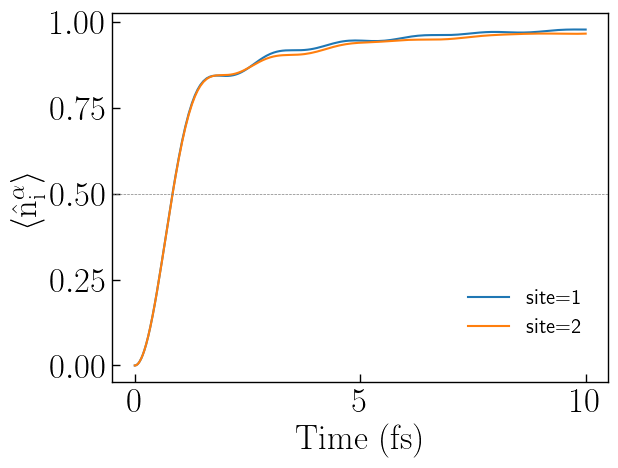

PyObject <matplotlib.lines.Line2D object at 0x7f0eaeea2930>

In [70]:

fig,axs =  plt.subplots(1,1)
site = 1
sites = range(1,6)
# for i in site 
#     axs.plot(ts_cd, cden_ta1[:,i]*det,label= "site=$(i)")#,alpha =1-0.2*i ) ### Charge bound current
#     axs.plot(ts_cd, cden_ta1[:,i+1]*det,label= "site=$(i+1)")#
# end
axs.plot(sol.t, cd[:,1]+cd[:,2],label= "site=$(1)")#,alpha =1-0.2*i ) ### Charge bound current
axs.plot(sol.t, cd[:,3]+cd[:,4],label= "site=$(2)")#
#axs.plot(sol.t, cd[:,3].+cd[:,4],label= "site=$(2)")

axs.set_ylabel(raw"$\langle\mathrm{\hat{n}^{\alpha}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
#plt.xlim(100,120)
plt.axhline(0.5,ls = "--",color="gray",lw = 0.5)
#plt.ylim(1-0.1,1+0.1)

In [53]:
cc[:,1]

2-element Vector{Float64}:
 0.0
 0.0

### Charge current 

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


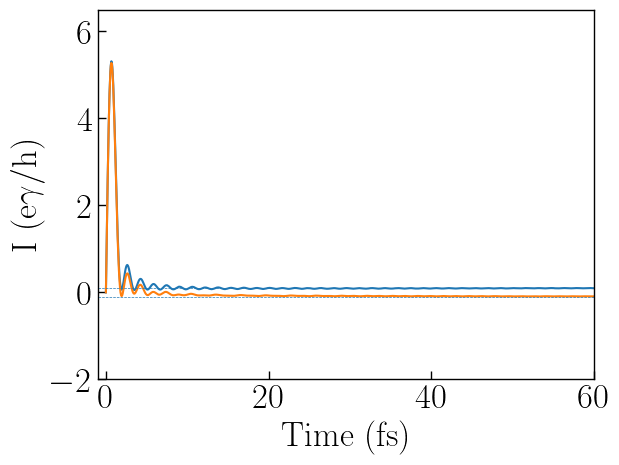

In [33]:
fig,axs = plt.subplots(1,1)

plt.plot(sol.t, cc[:,1])
plt.plot(sol.t, cc[:,2])
axs.set_ylabel(L"$\mathrm{I\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))
plt.xlim(-1,60)
plt.axhline(0.1,ls = "--",lw=0.5)
plt.axhline(-0.1,ls = "--",lw=0.5)
#plt.axhline(0.0,ls = "--",lw=0.5)
#plt.axhline(0.05,ls = "--",lw=0.5)
plt.ylim(-2,6.5)
plt.show()
#plt.ylim(-0.05,0.05)
#plt.ylim(-0.2,0.2)
#plt.ylim(0.1-1e-2,0.1+1e-2)
#plt.xlim(110,120)

In [30]:
# using DelimitedFiles
# cc_f = open("/home/jalil2/Documents/KBA/data/curr_KBE_jl.txt", "w+") 

# writedlm(cc_f, [sol.t Curr_left], ' ' )

# close(cc_f)

In [31]:
# using DelimitedFiles
# ccL_f = open("./data/ccL_KBE_jl.txt", "w+") 
# ccR_f = open("./data/ccR_KBE_jl.txt", "w+") 
# writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
# writedlm(ccR_f, [sol.t*hbar 4pi*Curr_right], ' ' )
# close(ccL_f)
# close(ccR_f)

In [32]:
#sol.t*hbar
#[sol.t*hbar  4pi*Curr_left]

LoadError: UndefVarError: `Curr_left` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [41]:
#4pi*Curr_left[end]/0.05

2.005188776546829

In [44]:
#4pi*Curr_left[end]

0.10025943882734145

In [56]:
#0.1/0.05
#0.096742516300053/0.05

In [57]:
#plt.plot(sol.t, Curr_right)

In [58]:
#0.05/0.2

## Save data 

In [34]:
using DelimitedFiles
path = "/home/jalil2/Documents/KBA/data"
name = "KBE";

### Charge current 

In [35]:
#ccL_f = open("./data/ccL_GKBA_jl.txt", "w+") 
cc_f = open("$(path)/cc_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cc_f, [sol.t cc], ' ' )
#writedlm(ccR_f, [ts_cc -4*pi*cc_αt[1,:]], ' ' )
#close(ccL_f)
close(cc_f)

### Local density 

In [36]:
cden_f = open("$(path)/cd_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cden_f, [sol.t cd], ' ' )
#close(ccL_f)
close(cden_f)